In [28]:
from util import ds
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
images_path = 'fall-detection.dataset/train/images'
labels_path = 'fall-detection.dataset/train/labels'

X_train, y_train = ds.load_dataset(images_path, labels_path)

images_path_val = 'fall-detection.dataset/valid/images'
labels_path_val = 'fall-detection.dataset/valid/labels'

X_val, y_val = ds.load_dataset(images_path_val, labels_path_val)

Total images loaded: 1263
Total labels loaded: 1263
Total images loaded: 240
Total labels loaded: 240


In [5]:
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32).permute(0, 3, 1, 2).to(device)
X_val_tensor = torch.tensor(np.array(X_val), dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.long).to(device)
y_val_tensor = torch.tensor(np.array(y_val), dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [6]:
class FallDetectionModel(nn.Module):
    def __init__(self):
        super(FallDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(624*624, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 6)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

model = FallDetectionModel()

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [7]:
for epoch in range(100):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch: {}, Loss: {}".format(epoch+1, running_loss))
    
torch.save(model.state_dict(), 'fall_detection_model.pth')

C:\Users\remig\PycharmProjects\FallDetection\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 1, Loss: 566.2555562257767
Epoch: 2, Loss: 566.19739818573
Epoch: 3, Loss: 566.1941903829575
Epoch: 4, Loss: 566.1859565973282
Epoch: 5, Loss: 566.1776777505875
Epoch: 6, Loss: 566.1649795770645
Epoch: 7, Loss: 566.1464383602142
Epoch: 8, Loss: 566.1228460073471
Epoch: 9, Loss: 566.1104035377502
Epoch: 10, Loss: 566.1019111871719
Epoch: 11, Loss: 566.0727337598801
Epoch: 12, Loss: 566.055924654007
Epoch: 13, Loss: 566.031212925911
Epoch: 14, Loss: 565.9999049901962
Epoch: 15, Loss: 565.9820034503937
Epoch: 16, Loss: 565.9377304315567
Epoch: 17, Loss: 565.9006404876709
Epoch: 18, Loss: 565.8587507009506
Epoch: 19, Loss: 565.8079853057861
Epoch: 20, Loss: 565.757425069809
Epoch: 21, Loss: 565.7259097099304
Epoch: 22, Loss: 565.6541857719421
Epoch: 23, Loss: 565.5970151424408
Epoch: 24, Loss: 565.5531471967697
Epoch: 25, Loss: 565.4743404388428
Epoch: 26, Loss: 565.4367599487305
Epoch: 27, Loss: 565.3192487955093
Epoch: 28, Loss: 565.2193063497543
Epoch: 29, Loss: 565.1677337884903

In [26]:
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print(f'test: {correct / total}')

os.makedirs('results', exist_ok=True)
with open('results/accuracy.txt', 'w') as f:
    f.write(f'test: {correct / total}\n')

test: 0.6208333333333333


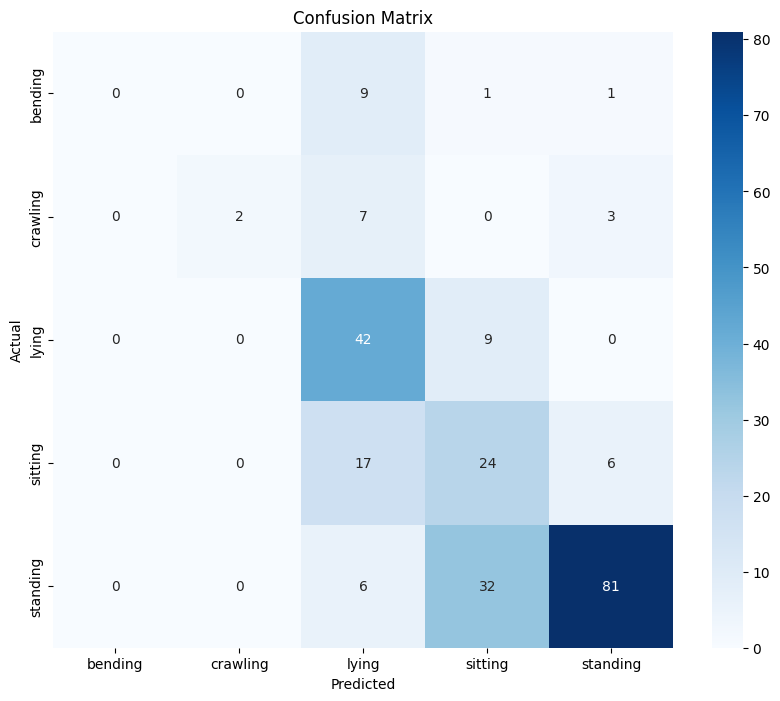

In [31]:
class_mapping = {
    0: 'bending',
    1: 'crawling',
    2: 'lying',
    3: 'sitting',
    4: 'standing',
}


cm = confusion_matrix(all_labels, all_predictions)
cm_labels = [class_mapping[i] for i in range(len(class_mapping))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('results/confusion_matrix.png')
plt.show()